In [2]:
import pandas as pd
import urllib
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

# <center>Tarea 3 Máquinas de Aprendizaje</center>

<center>
Patricio Horth M.<br>
Víctor Zúñiga M.<br>

22 de Diciembre de 2017
</center>



# 2. Bike Sharing

En la siguiente sección se probarán varias técnicas para resolver el problema de *Bike Sharing Demand* de *Kaggle* usando un subconjunto de los datos originales para entrenamiento, validación y prueba. Aquí se busca predecir una demanda, la cual será representada como un número entero en la variable *count*.

Vale mencionar que en el dataset además se tienen dos variables: *casual* y *registered*, y la suma de éstas da la variable *count*. En un principio, para evitar problemas debido a la correlación de variables, dejaremos éstas de lado.

## a) Ingreso y análisis descriptivo de los datos

In [61]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print('\nSummary - dataframe completo:\n')

print(df.describe())



Summary - dataframe completo:

         Unnamed: 0        season       holiday    workingday       weather  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean    5442.500000      2.506614      0.028569      0.680875      1.418427   
std     3142.661849      1.116174      0.166599      0.466159      0.633839   
min        0.000000      1.000000      0.000000      0.000000      1.000000   
25%     2721.250000      2.000000      0.000000      0.000000      1.000000   
50%     5442.500000      3.000000      0.000000      1.000000      1.000000   
75%     8163.750000      4.000000      0.000000      1.000000      2.000000   
max    10885.000000      4.000000      1.000000      1.000000      4.000000   

              temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159    

In [118]:
print("Numero de filas en conj. de entrenamiento:", len(dftrain))
print("Numero de filas en conj. de validacion:", len(dfval))
print("Numero de filas en conj. de prueba:", len(dftest))

Numero de filas en conj. de entrenamiento: 6562
Numero de filas en conj. de validacion: 2177
Numero de filas en conj. de prueba: 2147


In [62]:
df.head()

,Unnamed: 0,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
1,4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
2,5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
3,6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
4,7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3


In [63]:
df['datetime'].head()

0    2011-01-01 03:00:00
1    2011-01-01 04:00:00
2    2011-01-01 05:00:00
3    2011-01-01 06:00:00
4    2011-01-01 07:00:00
Name: datetime, dtype: object

Podemos notar que la columna *datetime* incluye datos de fecha y hora, los cuales pueden ser muy útiles, pero no podrán ser tratados con el formato actual.

Por ahora, asumiremos que el dato más importante a partir de *datetime* será la hora, por lo que crearemos una nueva característica *hour* a partir de ésta, y se dejará de lado *datetime*.

In [64]:
# Creamos una nueva columna "hora" u "hour" a partir de la columna string "datetime"

df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

df.describe()

,Unnamed: 0,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,5442.500000,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,3142.661849,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2721.250000,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,5442.500000,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,8163.750000,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,10885.000000,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


Si bien podemos utilizar técnicas de *scaling* y de estandarización para tratar las columnas de las características, será necesario ver que ocurre con la distribución de la variable *count*.

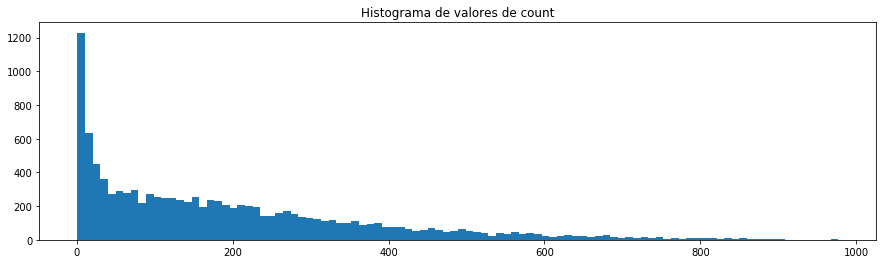

In [65]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de count")
plt.hist(df['count'],bins=100)
plt.show()

In [66]:
df['count'].head()

0    13
1     1
2     1
3     2
4     3
Name: count, dtype: int64

Podemos notar que se sigue una distribución muy sesgada hacia la izquierda (o sea, la mayoría de los datos son en valores pequeños). Por ahora los datos se dejarán como están, y se evaluará una posible transformación más adelante, con tal de poder comparar el desempeño de los modelos con o sin el sesgo.

Se presentarán también los histogramas de las variables *casual* y *registered*, las cuales están relacionadas a *count*.

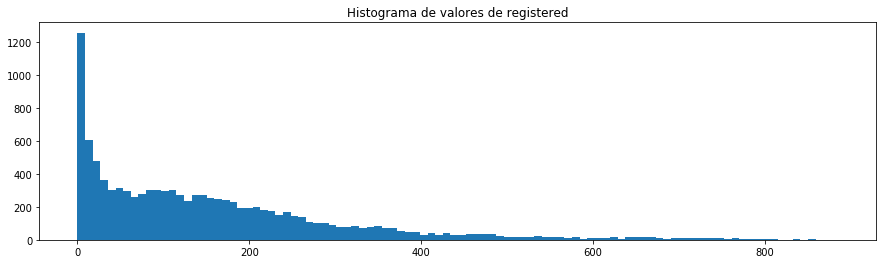

In [67]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de registered")
plt.hist(df['registered'],bins=100)
plt.show()

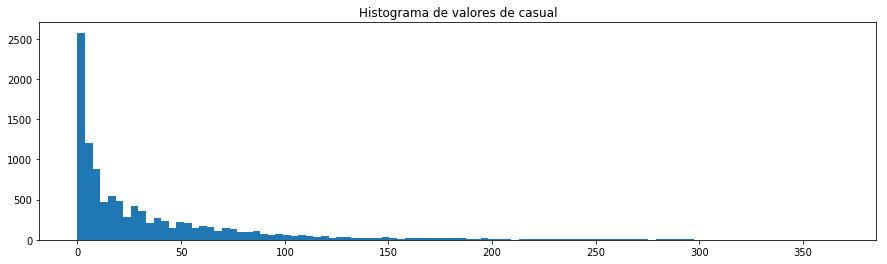

In [68]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de casual")
plt.hist(df['casual'],bins=100)
plt.show()

Ambas variables *target* también muestran un sesgo hacia la izquierda. Finalmente podemos calcular la norma de la resta entre *casual* y *registered*, respecto de *count* para demostrar esta correlación.

In [69]:
np.linalg.norm((df['casual'] + df['registered']) - df['count'], ord=2)

0.0

## b) Predicción de demanda mediante Árbol de Regresión

A continuación se utilizará un Árbol de Decisión (de tipo Regresión) para generar un modelo que prediga la demanda de bicicletas (*count*). Los árboles de decisión buscan crear un modelo basado en reglas que se pueden seguir e interpretar fácilmente al ir avanzando por una estructura de árbol, empezando desde una raíz y eligiendo la rama siguiente a recorrer según una regla respecto a una característica del *input*.

La construcción de éste árbol será hecha mediante el módulo *DecisionTreeRegressor* de scikit-learn, el cual por defecto utiliza MSE (Mean Squared Error o Error Cuadrático Medio) como medida de despeño, la cual será usada en cada nodo para ver cuál será el mejor *split* o corte para continuar la contrucción del árbol hacia abajo.

In [70]:
# Funciones de evaluación: original y para datos con transformación logarítmica

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_log(y_predict,y_true):
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG VAL TRAIN =0.554511
KAGG EVAL TEST =0.574239


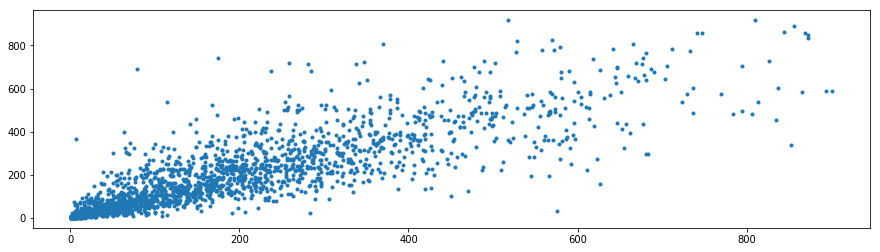

In [83]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt


Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG VAL TRAIN =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

In [72]:
model.feature_importances_

array([ 0.04118403,  0.00479538,  0.08005592,  0.02536423,  0.12763658,
        0.02357383,  0.06765909,  0.03557286,  0.59415807])

In [73]:
model.max_features_

9

In [75]:
model.tree_.max_depth

28

El árbol de regresión logra crear un modelo, sin embargo, éste tiene un error bastante alto que va creciendo a medida que aumenta el valor obtenido de *count*, respecto al valor original.

## c) Sintonización de parámetros para el Árbol de Regresión

A continuación se hará la sintonización de parámetros del árbol de regresión, con tal de obtener un mejor rendimiento. Para ello, se hará un Grid Search, o sea, se probarán todas las combinaciones posibles de varios conjuntos de parámetros, los cuales en este caso serán:

* *max_depth*, la máxima profundidad del árbol, entre 2 y 30.
* *min_samples_leaf*, el número mínimo de datos de entrenamiento que deben estar en un nodo para que éste pueda generar un *split* o corte hacia 2 nodos hijos, en el conjunto $[10,20,30,50,100,150,200,500,1000]$.
* *min_samples_split*, el número mínimo de datos de entrenamiento que deben estar en un nodo terminal u hoja, en el conjunto $[10,20,30,50,100,150,200,500,1000]$.

Además, este Grid Search hará automáticamente un Cross Validation 3-fold usando los datos de entrenamiento, con tal de asegurar parámetros que nos lleven a un modelo con un buen nivel de generalización.

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

model = Tree(random_state=0, min_samples_split=2, min_samples_leaf=1) #Arbol por defecto
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("\n Arbol por defecto:")
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

parameters = {'max_depth':range(2,30), 'min_samples_split': [10,20,30,50,100,150,200,500,1000], 'min_samples_leaf': [10,20,30,50,100,150,200,500,1000] }
clf = GridSearchCV(Tree(random_state=0), parameters, scoring=make_scorer(eval_bikemodel, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print ("Mejores params:", clf.best_params_)

Y_pred_val = clf.best_estimator_.predict(X_val)

print("\n Arbol con Grid Search CV:")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val)


 Arbol por defecto:
0.711209079858
KAGG EVAL VAL =0.554511
Mejores params: {'max_depth': 14, 'min_samples_leaf': 20, 'min_samples_split': 10}

 Arbol con Grid Search CV:
KAGG EVAL VAL =0.482457


Sabiendo que un número del orden de $10^1$ es lo mejor para los dos últimos parámetros del árbol, afinaremos la búsqueda:

In [86]:
parameters = {'max_depth':range(10,30), 'min_samples_split': range(10,30), 'min_samples_leaf': range(10,30) }
clf = GridSearchCV(Tree(random_state=0), parameters, scoring=make_scorer(eval_bikemodel, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print ("Mejores params:", clf.best_params_)

Mejores params: {'max_depth': 11, 'min_samples_leaf': 12, 'min_samples_split': 26}


In [87]:
# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

En conjunto de Validación
0.792968373194
KAGG EVAL VAL =0.477732
En conjunto de Prueba
0.789548859854
KAGG EVAL VAL =0.520036


Finalmente obtuvimos el siguiente conjunto de parámetros: {'max_depth': 14, 'min_samples_leaf': 20, 'min_samples_split': 10}.


## d) Preprocesamiento de los datos

Hemos llegado a un resultado mejor que antes, pero aún insuficiente. Hay dos puntos que será necesario tomar en cuenta si se quiere mejorar el puntaje:

* Hacer transaformaciones sobre los datos, con tal de que los algoritmos se comporten mejor
* Utilizar alguno de los datos de la columna *datetime* que fueron ignorados anteriormente

Para el primer punto, volveremos al histograma de la variable objetivo *count* que realizamos anteriormente.

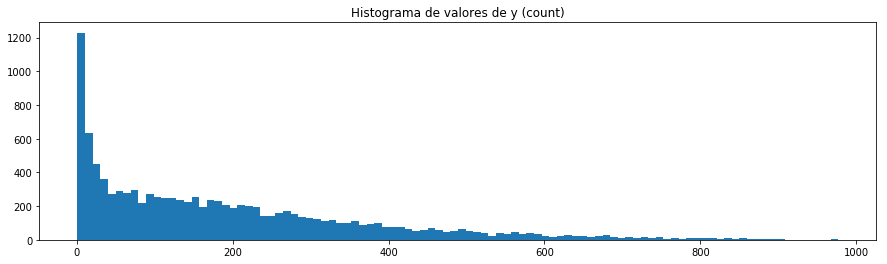

In [12]:
from matplotlib.pylab import hist, show
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

plt.title("Histograma de valores de y (count)")
#plt.xticks(range(1,12))
plt.hist(df['count'],bins=100)
plt.show()

Vemos que existen muchos datos con valores bajos: la variable tiene "*skewness*" hacia la izquierda. Con tal de buscar que los datos se comporten en forma cercana a una distribución normal, se probarán varias transformaciones:

* Transformación logarítmica
* Transformación *square root* o raíz cuadrada
* Transformación logarítmica elevada al cuadrado
* Transformación Box-Cox, definida como:

$$y_i^{(\lambda)} =
\begin{cases}
\dfrac{y_i^\lambda - 1}{\lambda} & \text{si } \lambda \neq 0, \\[8pt]
\ln{(y_i)} & \text{si } \lambda = 0,
\end{cases}$$

Scipy incluye utilidades para usar esta transformación, e incluso encontrar un buen *lambda* $\lambda$ [BoxCox]

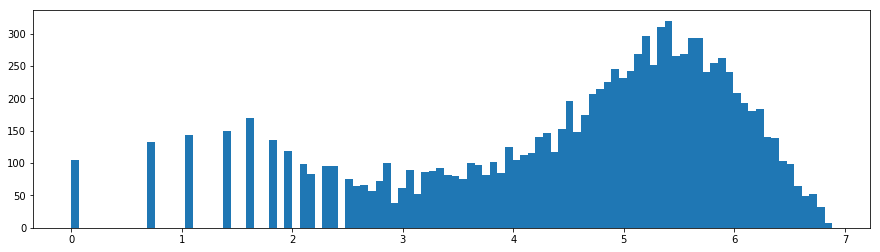

In [13]:
plt.hist((np.log(df['count'])),bins=100)
plt.show()

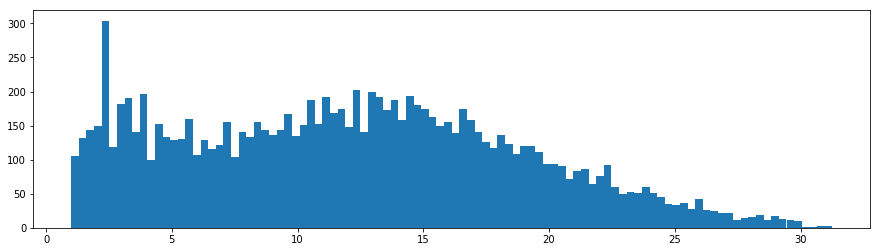

In [14]:
plt.hist((np.sqrt(df['count'])),bins=100)
plt.show()

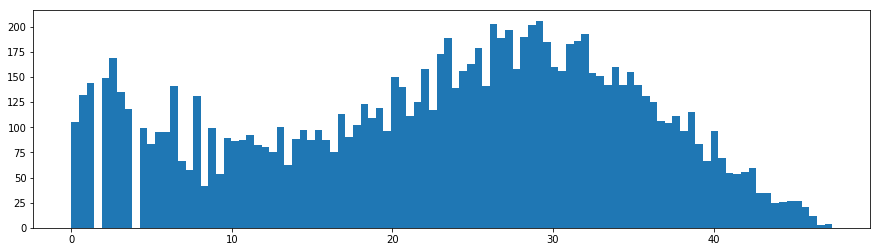

In [15]:
plt.hist((np.log(df['count'])**2),bins=100)
plt.show()

Lambda es 0.315670235792


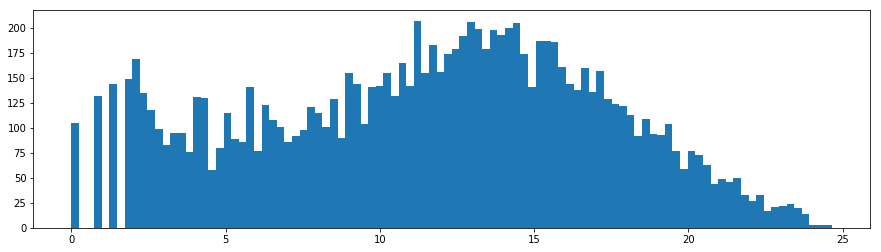

In [52]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.hist(boxcox(df['count'])[0],bins=100)
boxcox_lambda = boxcox(df['count'])[1]
print("Lambda es", boxcox_lambda)
plt.show()

Para el segundo punto, se utilizará no sólo la hora, si no también el día de la semana desde la columna *datetime*.

A continuación se probarán varias de estas transformaciones, junto con la columna nueva.

In [88]:
from sklearn.preprocessing import StandardScaler

df = pd.concat([dftrain,dfval,dftest])

# Creamos una nueva columna "hora" u "hour" a partir de la columna string "datetime"
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])

# Creamos una nueva columna "dias de la semana" o "cday" a partir de la columna string "datetime"
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek #0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])

Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday']]



Ydf=df.loc[:,'count']


def eval_bikemodel_sqrt(y_predict,y_true):
    diff = np.log(y_predict**2+1.0) - np.log(y_true**2+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_logsquared(y_predict,y_true):
    diff = np.log(np.exp(np.sqrt(y_predict))+1.0) - np.log(np.exp(np.sqrt(y_true))+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_boxcox(y_predict,y_true, lmbda):
    diff = np.log(inv_boxcox(y_predict, lmbda)+1.0) - np.log(inv_boxcox(y_true, lmbda)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Scaler_X = StandardScaler().fit(Xdf)
X_std = Scaler_X.transform(Xdf)

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]

SCORE TEST=0.822589
KAGG EVAL TRAIN =0.010646
KAGG EVAL VAL =0.539489
KAGG EVAL TEST =0.578443


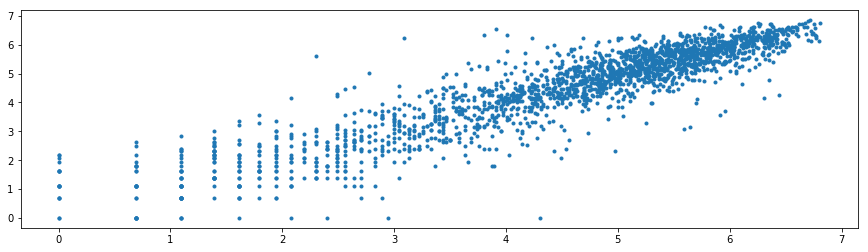

In [89]:
# Prueba 1, con log

Y_std = np.log(Ydf)
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_log(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_log(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

SCORE TEST=0.793169
KAGG EVAL TRAIN =0.010671
KAGG EVAL VAL =0.538698
KAGG EVAL TEST =0.554717


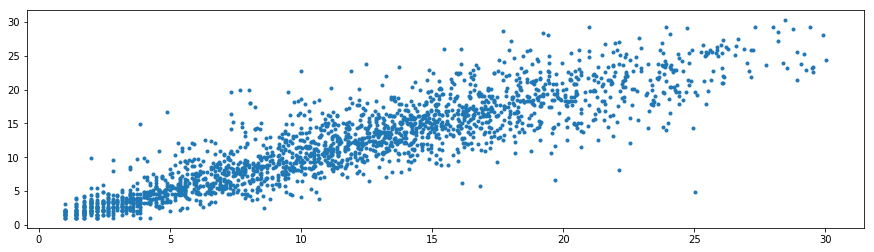

In [90]:
# Prueba 2, con sqrt

Y_std = np.sqrt(Ydf)
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_sqrt(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_sqrt(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_sqrt(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

SCORE TEST=0.822179
KAGG EVAL TRAIN =0.010653
KAGG EVAL VAL =0.544672
KAGG EVAL TEST =0.571342


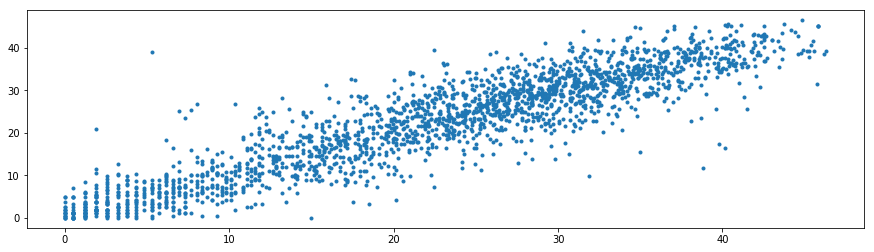

In [91]:
# Prueba 3, con logsquared

Y_std = (np.log(Ydf))**2
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_logsquared(Y_pred_train,Y_train)
kagg_val = eval_bikemodel_logsquared(Y_pred_val,Y_val)
kagg_test = eval_bikemodel_logsquared(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

SCORE TEST=0.809350
KAGG EVAL TRAIN =0.010655
KAGG EVAL VAL =0.555154
KAGG EVAL TEST =0.584134


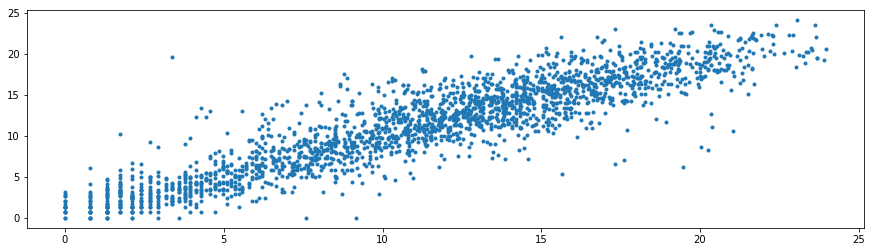

In [92]:
# Prueba 4, con boxcox

Y_std = boxcox(Ydf)[0]
boxcox_lambda = boxcox(Ydf)[1]
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel_boxcox(Y_pred_train,Y_train,boxcox_lambda)
kagg_val = eval_bikemodel_boxcox(Y_pred_val,Y_val,boxcox_lambda)
kagg_test = eval_bikemodel_boxcox(Y_pred_test,Y_test,boxcox_lambda)
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL VAL =%f"%kagg_val)
print("KAGG EVAL TEST =%f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.show()

|  | default | log   | sqrt | logsquared | boxcox |
|-----|--|------|-------|------------|--------|
|   R^2 SCORE | 0.703388 | 0.822589 | 0.793169 | 0.822179 | 0.809350 |
|   Kaggle Train | 0.028516 | 0.010646 | 0.010671 | 0.010653 | 0.010655 |
|   Kaggle Val | 0.554511 | 0.539489 | 0.538698 | 0.544672 | 0.555154 |
|   Kaggle Test | 0.574239| 0.578443 | 0.554717 | 0.571342 | 0.584134 |

Finalmente se escogerá la transformación logarítmica. Si bien no es la que logra el mejor puntaje absoluto, el *score* entregado por scikit-learn (que será el coeficiente $R^2$) es superior, y se logra un buen puntaje en el conjunto de validación.

In [94]:
Y_std = np.log(Ydf)
Y_train = Y_std[0:ntrain]
Y_val = Y_std[ntrain:nval]
Y_test = Y_std[nval:]

# MEJOR ARBOL SEGUN GridSearchCV anterior
model = Tree(max_depth= 11, min_samples_leaf= 12, min_samples_split= 26, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_val = model.predict(X_val)
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

0.888551210534
KAGG EVAL VAL =0.467601


In [95]:
parameters = {'max_depth':range(10,30), 'min_samples_split': range(10,30), 'min_samples_leaf': range(10,30) }
clf = GridSearchCV(Tree(random_state=0), parameters, scoring=make_scorer(eval_bikemodel, greater_is_better=False))
clf.fit(X_train,Y_train)
tree_model = clf.best_estimator_
print ("Mejores params:", clf.best_params_)

Mejores params: {'max_depth': 10, 'min_samples_leaf': 18, 'min_samples_split': 10}


In [98]:
# MEJOR ARBOL SEGUN GridSearchCV
model = Tree(max_depth= 10, min_samples_leaf= 18, min_samples_split= 10, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print(" En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("\n En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

 En conjunto de Validación
0.890942164386
KAGG EVAL VAL =0.464608

 En conjunto de Prueba
0.860209311604
KAGG EVAL VAL =0.518908


In [99]:
model = Tree(max_depth= 11, min_samples_leaf= 3, min_samples_split= 18, random_state= 0)#,max_depth=20,min_samples_leaf=100)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print(" En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("\n En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

 En conjunto de Validación
0.892357824533
KAGG EVAL VAL =0.458207

 En conjunto de Prueba
0.875143246149
KAGG EVAL VAL =0.486905


## e) Predicción de Demanda mediante SVM

Se dejarán de lado los árboles de decisión para probar otro tipo de modelos de regresión: las SVM (Support Vector Machines).  Éstas, en su forma lineal, van a intentar generar un hiperplano que funcione como una regresión lineal en el espacio de los datos, buscando maximizar un "márgen" (distancia entre puntos más cercanos entre un par de clases) al encontrar cuáles son los datos que son más relevantes para definir este márgen (los llamados vectores de soporte). Esto luego definirá un problema de optimización cuadrático, el cual se puede resolver con varias técnicas conocidas.

La búsqueda de una regresión lineal implica que se asume una relación lineal, sin embargo, mediante la técnica conocida como *Kernel trick* o el truco del Kernel, es posible hacer que la SVM pueda encontrar funciones no lineales que definen al *target* al aplicar una matriz de Kernel a los datos, lo que los proyecta en un espacio de mayor dimensión donde sí existe una relación lineal. Esto se realiza al reemplazar los productos puntos de la formulación de SVM por las funciones de Kernel. [SVM]

A continuación se probará crear una $\epsilon$-SVM con los parámetros por defecto (C=1, Kernel Gaussiano, $\epsilon$=$0.1$).
* Recordar que C se puede ver como un parámetro de regularización, ya que controla el *tradeoff* entre un bajo error de clasificación (con un conjunto de pruebas) y un márgen grande y óptimo. Por ejemplo, a mayor C se penaliza más a los *outliers* con tal de minimizar el error de entrenamiento, y a menor C se da holgura para ignorar *outliers* y tener mejor generalización. 
* Y además, el parámetro *epsilon* ($\epsilon$) definirá una banda (similar al márgen) que será insensible a error. Un *epsilon* muy bajo puede llevar a bajo error de entrenamiento y *overfitting* (sobreajuste), y un aumento de *epsilon* implica más holgura, pero además un número menor de vectores de soporte en el modelo final (un modelo más simple). [SVMParams]

In [16]:
def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

def eval_bikemodel_log(y_predict,y_true):
    diff = np.log(np.exp(y_predict)+1.0) - np.log(np.exp(y_true)+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

In [104]:
#load dataframes as before ...
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek
df['hour'] = pd.to_numeric(df['hour'])
df['cday'] = pd.to_numeric(df['cday'])
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour','cday']]

# Transformacion a vectores binarios
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday'])

# Y
Ydf=df.loc[:,'count']
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

# X
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X_std = scalerX.fit_transform(Xdf)

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]


from sklearn.svm import SVR
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

kagg_val = eval_bikemodel(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.302102748577
KAGG EVAL VAL =0.966316


Vemos que se obtuvo un puntaje bastante malo. ¿Por qué? No se ha hecho la transformación logarítmica, y los datos están muy sesgados, por lo que es posible que la SVM esté usando los vector de soporte incorrectos. Aplicando ésta, obtendremos lo siguiente:

In [105]:
# Y
# Tranformacion logaritmica
Ydf=np.log(df.loc[:,'count'])
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print(" En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("\n En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

 En conjunto de Validación
0.916631380463
KAGG EVAL VAL =0.399695

 En conjunto de Prueba
0.9061060821
KAGG EVAL VAL =0.420003


Logramos obtener un desempeño mucho mejor que con el árbol de clasificación. Vale mencionar que el tiempo de computación con SVM fue bastante mayor, por lo que en ciertas circunstancias podría no ser conveniente.

## f) Sintonización de Parámetros de SVM

Si bien logramos un buen resultado usando SVM con los parámetros por defecto (Kernel Gaussiano, $C=1$, epsilon igual a $0.1$), se podrían ajustar estos parámetros para obtener un mejor rendimiento.

Primero, se hará un *Grid Search* con Cross Validation en el conjunto de entrenamiento, probando con valores de C entre $10^-2$ y $10^2$, utilizando dos kernels distintos: Lineal y Gaussiano. Luego, utilizando los parámetros anteriores, se probará con diferentes valores de *epsilon*.

Sería mejor hacer de una sola vez un Grid Search con los tres parámetros, y poder probar con otros Kernels (como el polinomial y sigmoidal), pero el costo computacional va a ser excesivo, por lo que se harán por separado.

Finalmente, se agregarán los datos del conjunto de validación al conjunto de entrenamiento, con tal de obtener un mejor desempeño en el Cross Validation.

In [107]:
scalerX = StandardScaler()
X_std = scalerX.fit_transform(Xdf)

X_train_val = X_std[0:nval]
X_test = X_std[nval:]

Ydf=np.log(df.loc[:,'count'])
Y_train_val = Ydf[0:nval]
Y_test = Ydf[nval:]

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

parameters = {'C':np.logspace(-2, 2, 5), 'kernel': ['linear', 'rbf'] }
clf = GridSearchCV(SVR(verbose=1), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False), cv=2)
clf.fit(X_train_val,Y_train_val)
model = clf.best_estimator_
print ("Los mejores parametros son: ", clf.best_params_) 

Y_pred_val = model.predict(X_val)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Los mejores parametros son:  {'C': 1.0, 'kernel': 'rbf'}
En conjunto de Validación
0.943591111957
KAGG EVAL VAL =0.326244


In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

parameters = {'epsilon': np.logspace(-3, 3, 7) }
clf = GridSearchCV(SVR(verbose=1, C=1, kernel='rbf'), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False), cv=2)
clf.fit(X_train_val,Y_train_val)
model = clf.best_estimator_
print ("Los mejores parametros son: ", clf.best_params_) 

Y_pred_val = model.predict(X_val)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Los mejores parametros son:  {'epsilon': 0.10000000000000001}
En conjunto de Validación
0.943591111957
KAGG EVAL VAL =0.326244


Finalmente se obtiene que el mejor valor de C es el que está por defecto, o sea, 1, junto con el uso de un Kernel Gaussiano, y un valor de *epsilon* de 0.1. Estos son justamente los valores por defecto de la función *SVR()* de scikit-learn.

Para concluír esta sección, con tal de demostrar la no-linealidad y validar el uso de un Kernel Gaussiano, a continuación se van a comparar los puntajes obtenidos por una $\epsilon$-SVM lineal con una $\epsilon$-SVM Gaussiana. El resultado de esta $\epsilon$-SVM Gaussiana usando el conjunto de entrenamiento original será el modelo a mantener.

In [114]:
# SVM Lineal
model = SVR(C=1, kernel='linear', epsilon=0.1)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

En conjunto de Validación
0.789770560792
KAGG EVAL VAL =0.647314
En conjunto de Prueba
0.774659081829
KAGG EVAL VAL =0.659751


In [115]:
# SVM Kernel Gaussiano
model = SVR(C=1, kernel='rbf', epsilon=0.1)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print(" En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("\n En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG EVAL VAL =%f"%kagg_val) 

 En conjunto de Validación
0.916631380463
KAGG EVAL VAL =0.399695

 En conjunto de Prueba
0.9061060821
KAGG EVAL VAL =0.420003


## g) Prueba utilizando conjunto de validación para entrenamiento, y sintonización con Cross Validation con K=10

A continuación se hará una prueba utilizando el conjunto de validación como conjunto de entrenamiento. Además, el nuevo modelo será definido por nuevos hiperparámetros obtenidos mediante Grid Search con Cross Validation de $K=10$ *folds*.

Como parámetros de la SVM, se usará siempre el Kernel Gaussiano, se variará C entre $10^{-2}$ y $10^2$, y se variará *gamma* entre $10^{-2}$ y $10^{2}$

In [28]:
model = SVR(C=1, kernel='rbf') # Parametros por defecto
model.fit(X_val,Y_val) # Se usa conj de validacion para entrenar
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val) 

En conjunto de Validación
0.947751673108
KAGG EVAL VAL =0.311170
En conjunto de Prueba
0.891073266416
KAGG TEST VAL =0.451223


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer

# Probaremos con
# C = 10**-2, 10**-1, ... , 10**2
# gamma = 10**-2, 10**-1, ... , 10**2

parameters = {'C': np.logspace(-2, 2, 5), 'gamma': np.logspace(-2, 2, 5) }
clf = GridSearchCV(SVR(), parameters, scoring= make_scorer(eval_bikemodel_log, greater_is_better=False), cv=10)
clf.fit(X_val,Y_val)
model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val) 

-0.532374646819 {'C': 10.0, 'gamma': 0.01}
En conjunto de Validación
0.963456223862
KAGG EVAL VAL =0.261905
En conjunto de Prueba
0.897137292221
KAGG TEST VAL =0.440108


In [116]:
model = SVR(C=10, gamma= 0.01, kernel='rbf') # Parametros nuevos
model.fit(X_val,Y_val) # Se usa conj de validacion para entrenar
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val)

En conjunto de Validación
0.963456223862
KAGG EVAL VAL =0.261905
En conjunto de Prueba
0.897137292221
KAGG TEST VAL =0.440108


En forma evidente, el error de validación es bastante bajo, siendo que se usó este mismo conjunto para el entrenamiento. Sin embargo, el error de pruebas no logra ser mejor que otros de los modelos que hemos desarrollado.

Si bien esto se podría ver como una derrota, debemos considerar que el puntaje obtenido no es tan lejano al de otros modelos anteriores, y fue logrado con una menor cantidad de datos y con un ligero cambio en los parámetros. Esto implica que este conjunto de validación comparte en gran medida la distribución de los datos originales, y que aún siendo un muestreo, nos puede llevar a poder encontrar las características latentes del problema, y por ende, a un modelo útil.

## h) Ensamblado de dos máquinas de aprendizaje

A continuación se intentará utilizar el ensamblado de dos máquinas de aprendizaje: una entrenada para predescir la demanda de usuarios registrados, y una para los que no están registrados. 

La idea es que el target original, que era *count*, es lo mismo que la suma de las dos columnas *registered* y *casual*. Por lo tanto, se intentará hacer dos modelos para predescir estas variables, y luego para poder predescir *count*, sumamos las salidas de los dos modelos.

En este caso, existe el problema que ciertos valores de *registered* y de *casual* son cero, por lo tanto, la transformación logarítmica va a fallar. Para evitar calcular $log(0)$, se hará un corrimiento o *shift* a la transformación, que ahora será de $log(x+1)$ en vez de $log(x)$. De la misma forma, se deberá modificar la función de evaluación.

In [13]:
# Nueva funcion de evaluacion
def eval_bikemodel_log_shifted(y_predict,y_true):
    diff = np.log((np.exp(y_predict)) / (np.exp(y_true)))
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

# Ahora target sera "registered", se le aplica log(y+1)
Ydf=np.log(df.loc[:,'registered'] + 1)
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]

# SVM por defecto, C=1, gamma=0.1, kernel gaussiano
from sklearn.svm import SVR
model_reg = SVR()
model_reg.fit(X_train,Y_train)
Y_pred_train = model_reg.predict(X_train)
Y_pred_val = model_reg.predict(X_val)
Y_pred_test = model_reg.predict(X_test)

kagg_val = eval_bikemodel_log_shifted(Y_pred_val,Y_val)
print(model_reg.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.917671312581
KAGG EVAL VAL =0.402742


In [14]:
# Ahora target sera "casual"
Ydf=np.log(df.loc[:,'casual'] + 1)
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]


from sklearn.svm import SVR
model_casual = SVR()
model_casual.fit(X_train,Y_train)
Y_pred_train = model_casual.predict(X_train)
Y_pred_val = model_casual.predict(X_val)
Y_pred_test = model_casual.predict(X_test)

kagg_val = eval_bikemodel_log_shifted(Y_pred_val,Y_val)
print(model_casual.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

0.868086705656
KAGG EVAL VAL =0.533561


In [26]:
# Se aplica la inversa de log(x+1) a cada prediccion de los 2 modelos, y se suman
def predictor_combinado(model_one, model_two, X):
    #print(model_one.predict(X))
    #print(model_two.predict(X))
    #print(model.predict(X))
    return (np.exp(model_one.predict(X)) - 1) + (np.exp(model_two.predict(X)) - 1)

def eval_bikemodel_combinado(y_predict,y_true):
    #diff = np.log((np.exp(y_predict)) / (np.exp(y_true)))
    #return np.sqrt(np.sum(np.square(diff))/len(y_predict))
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Y_pred_train = predictor_combinado(model_casual, model_reg, X_train)
Y_pred_val = predictor_combinado(model_casual, model_reg, X_val)
Y_pred_test = predictor_combinado(model_casual, model_reg, X_test)

# Ya que la funcion predictor_combinado ya aplica la inversa de log(x+1), 
# no es necesario aplicarlo a los valores de referencia
Ydf = df.loc[:,'count']
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

In [27]:
print("En conjunto de Validación")
kagg_val = eval_bikemodel_combinado(Y_pred_val,Y_val)
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_combinado(Y_pred_test,Y_test)
print("KAGG EVAL TEST =%f"%kagg_val)

En conjunto de Validación
KAGG EVAL VAL =0.394721
En conjunto de Prueba
KAGG EVAL TEST =0.416887


Finalmente logramos un regresor que es ligeramente mejor que cada uno de los dos modelos que lo forman (con un error de validación de $\approx 0.3947$, mejor que). Esto abre las posibilidades de utilizar ensamblados de modelos para poder lograr un mejore regresor, y por ende, un mejor puntaje respecto a un sólo modelo.

## i) Ensamblado usando Random Forest

A continuación se utilizará uno de los algoritmos de ensamblado más comunes: Random Forest. Este algoritmo crea varios Árboles de Decisión (en este caso, siendo de Regresión) y luego crea un árbol final a partir de la combinación de éstos.

In [42]:
X_train = X_std[0:ntrain]
X_val = X_std[ntrain:nval]
X_test = X_std[nval:]

Ydf=np.log(df.loc[:,'count'])
Y_train = Ydf[0:ntrain]
Y_val = Ydf[ntrain:nval]
Y_test = Ydf[nval:]

from sklearn.ensemble import RandomForestRegressor

scores_val = []
scores_test = []

for i in range (1,20):
    model = RandomForestRegressor(n_estimators=i,random_state=0)
    model.fit(X_train,Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)

    scores_val.append(eval_bikemodel_log(Y_pred_val,Y_val))
    scores_test.append(eval_bikemodel_log(Y_pred_test,Y_test))

En conj. prueba, puntaje minimo fue 0.442417706927 con numero de arboles  18


En conj. prueba, puntaje minimo fue 0.442417706927


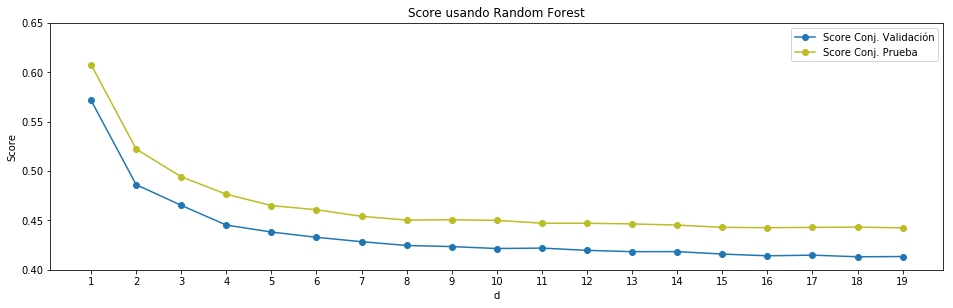

In [50]:
print("En conj. prueba, puntaje minimo fue", np.min(scores_test))

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,20)
plt.xticks(d)
plt.ylim([0.4,0.65])
plt.ylabel("Score")
plt.xlabel("Numero de Árboles")
plt.title("Score usando Random Forest")
plt.plot(d,scores_val, '-o', label='Score Conj. Validación', color='tab:blue')
plt.plot(d,scores_test, '-o', label='Score Conj. Prueba', color='tab:olive')
plt.legend(loc = "best")
plt.show()

In [56]:
scores_val = []
scores_test = []

for i in range (1,50):
    model = RandomForestRegressor(n_estimators=11,random_state=0, max_depth=i)
    model.fit(X_train,Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)

    scores_val.append(eval_bikemodel_log(Y_pred_val,Y_val))
    scores_test.append(eval_bikemodel_log(Y_pred_test,Y_test))

En conj. prueba, puntaje minimo fue 0.444158270252


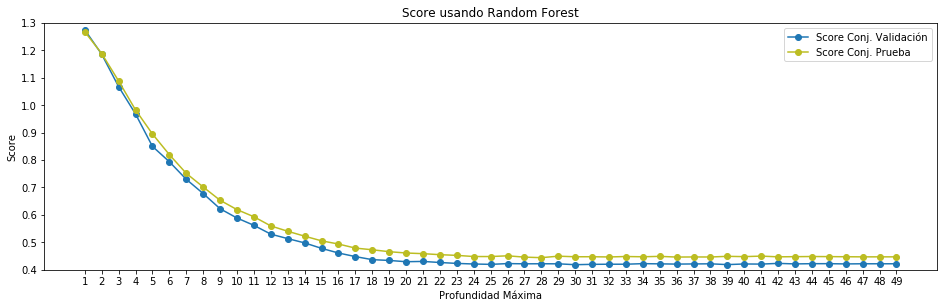

In [63]:
print("En conj. prueba, puntaje minimo fue", np.min(scores_test))

plt.figure(figsize=(16,10))
plt.subplot(211)
plt.xlabel("d")
d = range(1,50)
plt.xticks(d)
plt.ylim([0.4,1.3])
plt.ylabel("Score")
plt.xlabel("Profundidad Máxima")
plt.title("Score usando Random Forest")
plt.plot(d,scores_val, '-o', label='Score Conj. Validación', color='tab:blue')
plt.plot(d,scores_test, '-o', label='Score Conj. Prueba', color='tab:olive')
plt.legend(loc = "best")
plt.show()

In [65]:
model = RandomForestRegressor(n_estimators=11,random_state=0, max_depth=25)
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)

print("En conjunto de Validación")
kagg_val = eval_bikemodel_log(Y_pred_val,Y_val)
print(model.score(X_val,Y_val))
print("KAGG EVAL VAL =%f"%kagg_val) 

print("En conjunto de Prueba")
kagg_val = eval_bikemodel_log(Y_pred_test,Y_test)
print(model.score(X_test,Y_test))
print("KAGG TEST VAL =%f"%kagg_val)

En conjunto de Validación
0.908883677039
KAGG EVAL VAL =0.419806
En conjunto de Prueba
0.892785434352
KAGG TEST VAL =0.448239


Se puede apreciar que la ganancia de puntaje (en este caso, la reducción del *score*) es muy apreciable a medida que se aumenta la profundidad máxima de los árboles, y la cantidad de árboles a desarrollar. Sin embargo, estas ganancias se reducen de a poco hasta ser marginales. Eligiendo 11 árboles y una profundidad máxima de 25 niveles, se logra llegar a un puntaje superior a los obtenidos anteriormente con árboles de regresión individuales.

Como conclusiones del ejercicio, podemos ver la eficacia de los árboles de regresión y las SVMs en la predicción de variables numéricas que no siguen funciones lineales. Con árboles de regresión obtenemos modelos que, según el ajuste de parámetros, pueden llegar a ser suficientemente exactos para ciertas circunstancias, y son fáciles de interpretar. Con SVMs podemos obtener aproximaciones muy buenas de la distribución original de las variables *target* continuas, pero bajo un costo computacional mucho mayor, y bajo el ajuste de otros parámetros con tal de evitar *overfitting* o sobreajuste.

Finalmente, con modelos ensamblados podemos utilizar lo aprendido por varios modelos y obtener una predicción mejor que cualquiera de los modelos individuales, lo cual puede ser útil en aplicaciones prácticas, donde buscamos una mayor certeza en las predicciones y una buena generalización.

# Referencias

* [BoxCox] Box-Cox Normality Plot. Box-Cox normality Plot. Obtenido de http://www.itl.nist.gov/div898/handbook/eda/section3/eda336.htm
* [SVM] R. Berwick. An idiot guide's to SVMs. Obtenido de http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf
* [SVMParams] SVMS. SVM Parameters. Obtenido de http://www.svms.org/parameters/